# **Import Libraries**

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import copy
import numpy as np

In [16]:
import os
os.listdir("/kaggle/input")


['eurosat-dataset']

# **Set Up**

In [17]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Path
dataset_path ="/kaggle/input/eurosat-dataset/EuroSAT"

In [18]:
transform_classifier = transforms.Compose([
    transforms.Resize(72),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
])

In [19]:
# Load dataset
full_dataset = datasets.ImageFolder(dataset_path, transform=transform_classifier)
num_classes = len(full_dataset.classes)

# Train - Test - Validation
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

# **Load MoCo Encoder**

In [20]:
class EncoderWrapper(nn.Module):
    def __init__(self, out_dim=128, checkpoint_path=None):
        super().__init__()
        backbone = models.resnet50(weights=None)   # replaces deprecated pretrained=False
        dim_backbone = backbone.fc.in_features
        backbone.fc = nn.Identity()                # backbone outputs 2048-d features
        self.backbone = backbone
        self.encoder = self.backbone               # alias so .encoder works

        # projection head for contrastive pretraining
        self.proj_head = nn.Sequential(
            nn.Linear(dim_backbone, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, out_dim)
        )

        if checkpoint_path:
            self.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))

    def forward(self, x, proj=True):
        h = self.backbone(x)        # representation (e.g., 2048-d)
        if proj:
            return self.proj_head(h)  # 128-d for contrastive
        return h                      # backbone features for linear eval


# Instantiate and save encoder (inner backbone weights)
moco_encoder = EncoderWrapper(out_dim=128)

# **MoCo Momentum Encoder + Queue**

In [21]:
# Momentum encoder setup
query_encoder = EncoderWrapper().to(device)
key_encoder = EncoderWrapper().to(device)

key_encoder.load_state_dict(query_encoder.state_dict())
for param in key_encoder.parameters():
    param.requires_grad = False  # Freeze key encoder

# Momentum update
def momentum_update (query_encoder,key_encoder, m=0.9995):
   for param_q, param_k in zip(query_encoder.parameters(), key_encoder.parameters()):
        param_k.data = param_k.data * m + param_q.data * (1. - m)

K = 4096             # queue size
proj_dim = 128  # must match EncoderWrapper(out_dim)
queue = F.normalize(torch.randn(proj_dim, K, device=device), dim=0)  # [128, K]
queue_ptr = 0

@torch.no_grad()
def dequeue_and_enqueue(keys):
    # keys: [N, proj_dim]
    global queue, queue_ptr
    bsz = keys.shape[0]
    ptr = queue_ptr
    end = ptr + bsz
    if end <= K:
        queue[:, ptr:end] = keys.T
    else:
        first = K - ptr
        queue[:, ptr:] = keys[:first].T
        queue[:, :bsz-first] = keys[first:].T
    queue_ptr = (ptr + bsz) % K

# **MoCo Pretraining Loop**

In [22]:
# MoCo v2-style augments for EuroSAT (64x64)
moco_transform = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 2.0))], p=0.5),
    transforms.ToTensor(),
    # Optional but recommended if you’ll ever swap to ImageNet-pretrained encoders:
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class ContrastiveDataset(Dataset):
    def __init__(self, base_dataset):
        self.dataset = base_dataset
    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        return moco_transform(x), moco_transform(x)
    def __len__(self):
        return len(self.dataset)

In [23]:
# Path from EuroSAT dataset
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"  

# Load base dataset (without transform)
base_dataset = ImageFolder(data_dir)

# Wrap with contrastive dataset
contrastive_dataset = ContrastiveDataset(base_dataset)

# DataLoader
contrastive_loader = DataLoader(contrastive_dataset, batch_size=64, shuffle=True, num_workers=2)

In [24]:
save_path = "/kaggle/working/best_moco_encoder.pth"
best_loss = float('inf')
moco_losses = []  # Track pretraining loss
temperature = 0.05  # Lower temperature for better separation
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(query_encoder.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
warmup_epochs = 10
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)

for epoch in range(10):
    query_encoder.train()
    key_encoder.eval()

    running = 0.0
    for x_q, x_k in contrastive_loader:
        x_q, x_k = x_q.to(device), x_k.to(device)

        # 1) momentum update before key forward
        momentum_update(query_encoder, key_encoder, m=0.9995)  # Increased momentum for more stable key encoder)

        # 2) forward
        q = query_encoder(x_q, proj=True)                 # [N,128]
        with torch.no_grad():
            k = key_encoder(x_k, proj=True)               # [N,128]

        # 3) L2-normalize
        q = F.normalize(q, dim=1)
        k = F.normalize(k, dim=1)
        
        # 4) logits and loss
        l_pos = torch.einsum('nc,nc->n', q, k).unsqueeze(-1)      # [N, 1]
        l_neg = torch.einsum('nc,ck->nk', q, queue)               # [N, K]
        logits = torch.cat([l_pos, l_neg], dim=1) / temperature   # [N, 1+K]
        labels = torch.zeros(logits.size(0), dtype=torch.long, device=device)
        
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(query_encoder.parameters(), max_norm=1.0)
        optimizer.step()
        if epoch < warmup_epochs:
            warmup_scheduler.step()
        else:
            scheduler.step()
        running += loss.item()
        
        # 5) enqueue the current keys
        with torch.no_grad():
            dequeue_and_enqueue(k)

    avg_loss = running / len(contrastive_loader)
    moco_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: loss={avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(query_encoder.state_dict(), save_path)
        print(f" Saved best at epoch {epoch+1}")

np.savetxt("/kaggle/working/moco_pretraining_loss.txt", np.array(moco_losses))

Epoch 1: loss=6.4816
 Saved best at epoch 1
Epoch 2: loss=6.7120
Epoch 3: loss=6.5232
Epoch 4: loss=6.5470
Epoch 5: loss=7.0021
Epoch 6: loss=7.3230
Epoch 7: loss=7.3713
Epoch 8: loss=7.2899
Epoch 9: loss=7.2666
Epoch 10: loss=7.4246


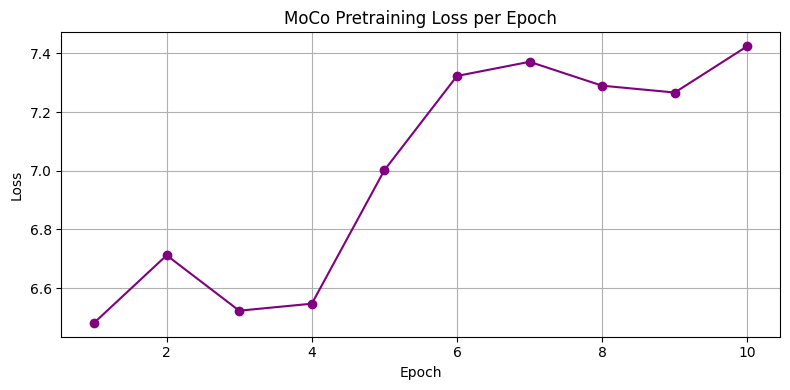

In [25]:
# Plot Pertraining Loss
moco_losses = np.loadtxt("/kaggle/working/moco_pretraining_loss.txt")

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(moco_losses) + 1), moco_losses, marker='o', linestyle='-', color='purple')
plt.title("MoCo Pretraining Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# **Linear Classifier with Frozen MoCo Encoder**

In [26]:
enc = EncoderWrapper(out_dim=128)
enc.load_state_dict(torch.load("/kaggle/working/best_moco_encoder.pth", map_location=device))
enc.to(device)

class LinearEvalClassifier(nn.Module):
    def __init__(self, encoder, feat_dim=2048, num_classes=10):
        super().__init__()
        # freeze backbone
        for p in encoder.parameters():
            p.requires_grad = False
        self.encoder = encoder
        self.fc = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            feats = self.encoder(x, proj=False)  # backbone features, not projector
        return self.fc(feats)

model = LinearEvalClassifier(enc, feat_dim=2048, num_classes=num_classes).to(device)
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0)
criterion = nn.CrossEntropyLoss()


train_losses, val_losses = [], []
train_accs,  val_accs  = [],  []

best_val_loss = float("inf")

epochs = 10

for epoch in range(epochs):
    # Train
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(query_encoder.parameters(), max_norm=1.0)
        optimizer.step()
        if epoch < warmup_epochs:
            warmup_scheduler.step()
        else:
            scheduler.step()

        bs = labels.size(0)
        running_loss += loss.item() * bs
        correct += (logits.argmax(1) == labels).sum().item()
        total += bs

    train_losses.append(running_loss / max(1, total))
    train_accs.append(correct / max(1, total))

    # Validation
    model.eval()
    val_running_loss, vcorrect, vtotal = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            vlogits = model(images)
            vloss = criterion(vlogits, labels)

            bs = labels.size(0)
            val_running_loss += vloss.item() * bs
            vcorrect += (vlogits.argmax(1) == labels).sum().item()
            vtotal += bs

    val_loss = val_running_loss / max(1, vtotal)
    val_acc  = vcorrect / max(1, vtotal)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"[LinearEval] Epoch {epoch+1}/{epochs}  "
          f"TrainLoss {train_losses[-1]:.4f}  TrainAcc {train_accs[-1]*100:.2f}%  "
          f"ValLoss {val_loss:.4f}  ValAcc {val_acc*100:.2f}%")

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/kaggle/working/best_classifier.pth")
        print("  Saved best linear classifier")

[LinearEval] Epoch 1/10  TrainLoss 67.7979  TrainAcc 32.62%  ValLoss 72.1341  ValAcc 28.91%
  Saved best linear classifier
[LinearEval] Epoch 2/10  TrainLoss 60.0913  TrainAcc 35.61%  ValLoss 41.8001  ValAcc 42.79%
  Saved best linear classifier
[LinearEval] Epoch 3/10  TrainLoss 57.6714  TrainAcc 37.07%  ValLoss 60.0349  ValAcc 38.69%
[LinearEval] Epoch 4/10  TrainLoss 57.6861  TrainAcc 37.18%  ValLoss 48.0384  ValAcc 34.96%
[LinearEval] Epoch 5/10  TrainLoss 55.2827  TrainAcc 37.50%  ValLoss 105.5675  ValAcc 29.38%
[LinearEval] Epoch 6/10  TrainLoss 58.8750  TrainAcc 38.72%  ValLoss 45.4620  ValAcc 42.72%
[LinearEval] Epoch 7/10  TrainLoss 60.1498  TrainAcc 38.15%  ValLoss 64.4243  ValAcc 34.30%
[LinearEval] Epoch 8/10  TrainLoss 61.9979  TrainAcc 37.65%  ValLoss 60.0081  ValAcc 47.53%
[LinearEval] Epoch 9/10  TrainLoss 58.7046  TrainAcc 38.53%  ValLoss 58.2872  ValAcc 38.05%
[LinearEval] Epoch 10/10  TrainLoss 51.7858  TrainAcc 40.52%  ValLoss 44.2634  ValAcc 42.67%


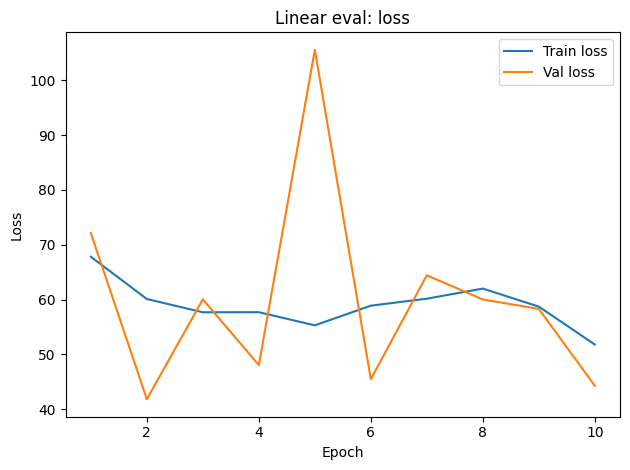

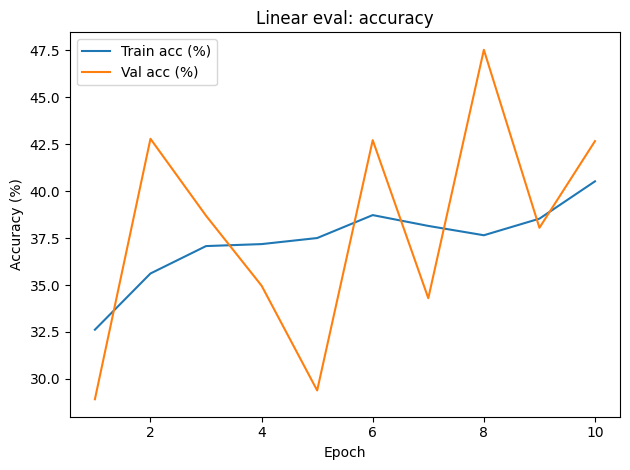

Best epoch (min val loss): 2  |  Val acc: 42.79%


In [27]:
epochs = range(1, len(train_losses) + 1)

# Loss
plt.figure()
plt.plot(epochs, train_losses, label='Train loss')
plt.plot(epochs, val_losses, label='Val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Linear eval: loss')
plt.legend(); plt.tight_layout()
plt.show()

# Accuracy
plt.figure()
plt.plot(epochs, [a * 100 for a in train_accs], label='Train acc (%)')
plt.plot(epochs, [a * 100 for a in val_accs], label='Val acc (%)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Linear eval: accuracy')
plt.legend(); plt.tight_layout()
plt.show()

# Best epoch summary
best_epoch = int(np.argmin(val_losses)) + 1
print(f"Best epoch (min val loss): {best_epoch}  |  Val acc: {val_accs[best_epoch-1]*100:.2f}%")

# **Evaluate on test set**

In [28]:
# Final Test Set Evaluation
model.eval()
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct / total
print(f"\nFinal Test Accuracy: {test_acc:.2%}, Test Loss: {test_loss:.4f}")


Final Test Accuracy: 42.81%, Test Loss: 44.7125
